In [1]:
!pip install opendatasets --upgrade --quiet
!pip install kaggle --quiet

In [2]:
import opendatasets as od
import os
import random
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.models import Model
import tensorflow as tf
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
import time

In [3]:
dataset_url = 'https://www.kaggle.com/datasets/akashrayhan/yoga-82'
od.download(dataset_url)
data_dir = 'yoga-82'

def load_images_from_directory(directory):
    images, labels = [], []
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            for file in os.listdir(subdir_path):
                if file.endswith(".jpg"):
                    image_path = os.path.join(subdir_path, file)

                    # Load and preprocess the image
                    image = cv2.imread(image_path)
                    if image is not None:
                        image = cv2.resize(image, (32, 32))
                        image = img_to_array(image)
                        images.append(image)

                        # Use the subfolder name as the label
                        labels.append(subdir)

    # Convert to numpy arrays and normalize the images
    return np.array(images, dtype="float") / 255.0, np.array(labels)

# Define paths for train, test, and validation sets
train_path = 'yoga-82/train'
test_path = 'yoga-82/test'
valid_path = 'yoga-82/valid'

# Load datasets
x_train, y_train = load_images_from_directory(train_path)
x_test, y_test = load_images_from_directory(test_path)
x_valid, y_valid = load_images_from_directory(valid_path)

# Check if data has been loaded
print(f'Training samples: {len(x_train)}, Testing samples: {len(x_test)}, Validation samples: {len(x_valid)}')

# Binarize the labels
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
y_valid = lb.transform(y_valid)

# Verify the classes found
print("Classes:", lb.classes_)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: harzh01
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/akashrayhan/yoga-82


100%|██████████| 2.36G/2.36G [00:27<00:00, 90.7MB/s]



Training samples: 11607, Testing samples: 1760, Validation samples: 3333
Classes: ['Akarna_Dhanurasana' 'Bharadvajas_Twist_pose_or_Bharadvajasana_I_'
 'Boat_Pose_or_Paripurna_Navasana_' 'Bound_Angle_Pose_or_Baddha_Konasana_'
 'Bow_Pose_or_Dhanurasana_' 'Bridge_Pose_or_Setu_Bandha_Sarvangasana_'
 'Camel_Pose_or_Ustrasana_' 'Cat_Cow_Pose_or_Marjaryasana_'
 'Chair_Pose_or_Utkatasana_' 'Child_Pose_or_Balasana_'
 'Cobra_Pose_or_Bhujangasana_' 'Cockerel_Pose' 'Corpse_Pose_or_Savasana_'
 'Cow_Face_Pose_or_Gomukhasana_' 'Crane_(Crow)_Pose_or_Bakasana_'
 'Dolphin_Plank_Pose_or_Makara_Adho_Mukha_Svanasana_'
 'Dolphin_Pose_or_Ardha_Pincha_Mayurasana_'
 'Downward-Facing_Dog_pose_or_Adho_Mukha_Svanasana_'
 'Eagle_Pose_or_Garudasana_' 'Eight-Angle_Pose_or_Astavakrasana_'
 'Extended_Puppy_Pose_or_Uttana_Shishosana_'
 'Extended_Revolved_Side_Angle_Pose_or_Utthita_Parsvakonasana_'
 'Extended_Revolved_Triangle_Pose_or_Utthita_Trikonasana_'
 'Feathered_Peacock_Pose_or_Pincha_Mayurasana_'
 'Firefly_Pose_

In [4]:
def teacher_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Define the student model (fewer layers)
def student_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

input_shape = (32, 32, 3)  # Updated input shape
num_classes = len(lb.classes_)


In [5]:
teacher = teacher_model(input_shape, num_classes)
student = student_model(input_shape, num_classes)

# Define a learning rate scheduler function
def lr_scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.1)) if epoch >= 10 else float(lr)

# Compile and train the teacher model
teacher.compile(optimizer=SGD(learning_rate=1e-2, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
teacher.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# Precompute teacher's predictions for distillation
teacher_preds = teacher.predict(x_train)

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 155s 424ms/step - accuracy: 0.0287 - loss: 4.3509 - val_accuracy: 0.0284 - val_loss: 4.3237 - learning_rate: 0.0100
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 182s 370ms/step - accuracy: 0.0320 - loss: 4.3061 - val_accuracy: 0.0239 - val_loss: 4.3198 - learning_rate: 0.0100
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 134s 370ms/step - accuracy: 0.0286 - loss: 4.3021 - val_accuracy: 0.0318 - val_loss: 4.3109 - learning_rate: 0.0100
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 142s 370ms/step - accuracy: 0.0304 - loss: 4.2893 - val_accuracy: 0.0403 - val_loss: 4.2201 - learning_rate: 0.0100
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 146s 379ms/step - accuracy: 0.0508 - loss: 4.1563 - val_accuracy: 0.0812 - val_loss: 3.9082 - learning_rate: 0.0100
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 134s 368ms/step - accuracy: 0.0791 - loss: 3.9155 - val_accuracy: 0.1432 - val_loss: 3.5287 - learning_rate: 0.0100
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 142s 369ms/step - accura

In [6]:
def distillation_loss(y_true, y_pred, teacher_preds, student_model, temperature=3.0, alpha=0.1):
    # Get predictions from the teacher model and apply temperature scaling
    teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
    y_true = tf.keras.activations.softmax(y_true / temperature)
    y_pred = tf.keras.activations.softmax(y_pred / temperature)
    teacher_batch_preds = tf.keras.activations.softmax(teacher_batch_preds / temperature)

    # Compute the soft loss and hard loss components
    soft_loss = tf.keras.losses.categorical_crossentropy(teacher_batch_preds, y_pred)
    hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

    # Ensure the first layer has weights
    first_layer = student_model.layers[0]
    if hasattr(first_layer, 'weights') and len(first_layer.weights) > 0:
        # Extract weights from the first layer and compute nuclear norm
        first_layer_weights = first_layer.weights[0]  # Access weights directly
        singular_values = tf.linalg.svd(first_layer_weights, compute_uv=False)
        nuclear_norm = tf.reduce_sum(singular_values)
    else:
        # If no weights exist, set nuclear_norm to 0
        nuclear_norm = 0

    # Return the combined loss
    return alpha * soft_loss + (1. - alpha) * hard_loss + alpha * nuclear_norm

In [7]:
teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')

Teacher test accuracy: 41.48%


In [13]:
student.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds, student_model=student),
    metrics=['accuracy']
)
student.fit(x_train, y_train, batch_size=32, epochs=25, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])


Epoch 1/25
363/363 ━━━━━━━━━━━━━━━━━━━━ 39s 92ms/step - accuracy: 0.7199 - loss: 4.4063 - val_accuracy: 0.3517 - val_loss: 4.4066 - learning_rate: 0.0010
Epoch 2/25
363/363 ━━━━━━━━━━━━━━━━━━━━ 39s 86ms/step - accuracy: 0.7820 - loss: 4.4062 - val_accuracy: 0.3369 - val_loss: 4.4066 - learning_rate: 0.0010
Epoch 3/25
363/363 ━━━━━━━━━━━━━━━━━━━━ 31s 86ms/step - accuracy: 0.7795 - loss: 4.4062 - val_accuracy: 0.3619 - val_loss: 4.4066 - learning_rate: 0.0010
Epoch 4/25
363/363 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - accuracy: 0.7987 - loss: 4.4062 - val_accuracy: 0.3489 - val_loss: 4.4066 - learning_rate: 0.0010
Epoch 5/25
363/363 ━━━━━━━━━━━━━━━━━━━━ 41s 86ms/step - accuracy: 0.7948 - loss: 4.4062 - val_accuracy: 0.3483 - val_loss: 4.4066 - learning_rate: 0.0010
Epoch 6/25
363/363 ━━━━━━━━━━━━━━━━━━━━ 42s 87ms/step - accuracy: 0.7919 - loss: 4.4062 - val_accuracy: 0.3483 - val_loss: 4.4066 - learning_rate: 0.0010
Epoch 7/25
363/363 ━━━━━━━━━━━━━━━━━━━━ 40s 85ms/step - accuracy: 0.8012 - l

In [14]:
#teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
student_score = student.evaluate(x_test, y_test, verbose=0)
#print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')
print(f'Student test accuracy: {student_score[1] * 100:.2f}%')

Student test accuracy: 35.17%


In [15]:
from sklearn.metrics import classification_report
import time

def evaluate_model(model, x_test, y_test):
    # Predict the labels
    start_time = time.time()
    y_pred_probs = model.predict(x_test)
    inference_time = time.time() - start_time

    # Get the predicted classes
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate precision, recall, F1 score
    report = classification_report(y_true, y_pred, target_names=lb.classes_)

    # Print the metrics
    print(report)
    print(f"Inference Time: {inference_time:.4f} seconds")
    return y_pred_probs

print("=== Teacher Model Evaluation ===")
teacher_pred_probs = evaluate_model(teacher, x_test, y_test)

print("\n=== Student Model Evaluation ===")
student_pred_probs = evaluate_model(student, x_test, y_test)

=== Teacher Model Evaluation ===
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step
                                                                           precision    recall  f1-score   support

                                                       Akarna_Dhanurasana       0.71      0.56      0.62         9
                              Bharadvajas_Twist_pose_or_Bharadvajasana_I_       0.10      0.11      0.11         9
                                         Boat_Pose_or_Paripurna_Navasana_       0.69      0.65      0.67        31
                                     Bound_Angle_Pose_or_Baddha_Konasana_       0.32      0.23      0.27        26
                                                 Bow_Pose_or_Dhanurasana_       0.73      0.70      0.71        23
                                 Bridge_Pose_or_Setu_Bandha_Sarvangasana_       0.39      0.57      0.46        28
                                                 Camel_Pose_or_Ustrasana_       0.60      0.44      0.51        34
     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:

alpha_values = [0.1, 0.2, 0.3, 0.4, 0.5]
f1_scores = []
accuracies = []
precisions = []
recalls = []
inference_times = []

teacher_preds = teacher.predict(x_train)

# Function to evaluate F1-score, accuracy, precision, recall, and inference time for a given model and alpha
def evaluate_student_with_alpha(alpha):
    # Redefine distillation loss function with current alpha
    def distillation_loss(y_true, y_pred, teacher_preds, student_model, temperature=3.0, alpha=alpha):
        # Scale teacher predictions and student predictions by temperature
        teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
        y_true = tf.keras.activations.softmax(y_true / temperature)
        y_pred = tf.keras.activations.softmax(y_pred / temperature)
        teacher_batch_preds = tf.keras.activations.softmax(teacher_batch_preds / temperature)

        # Calculate soft loss and hard loss
        soft_loss = tf.keras.losses.categorical_crossentropy(teacher_batch_preds, y_pred)
        hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

        # Ensure the first layer has weights
        first_layer = student_model.layers[0]
        if hasattr(first_layer, 'weights') and len(first_layer.weights) > 0:
            # Extract first layer's weights from the student model and compute nuclear norm
            first_layer_weights = first_layer.weights[0]  # Access weights directly
            singular_values = tf.linalg.svd(first_layer_weights, compute_uv=False)
            nuclear_norm = tf.reduce_sum(singular_values)
        else:
            # If no weights exist, set nuclear_norm to 0
            nuclear_norm = 0

        # Combine losses with nuclear norm regularization
        return alpha * (soft_loss + nuclear_norm) + (1. - alpha) * hard_loss

    # Compile the student model with the new distillation loss
    student.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds, student_model=student),
        metrics=['accuracy']
    )

    # Train the student model
    student.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test),
                callbacks=[LearningRateScheduler(lr_scheduler)], verbose=0)

    # Predict and evaluate
    start_time = time.time()
    y_pred_probs = student.predict(x_test)
    inference_time = time.time() - start_time
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate and store F1-score, accuracy, precision, recall, and inference time
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # Append the results
    f1_scores.append(f1)
    accuracies.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    inference_times.append(inference_time)

    # Print classification report
    print(f"=== Classification Report for Alpha: {alpha} ===")
    print(classification_report(y_true, y_pred, target_names=lb.classes_))
    print(f"Inference Time: {inference_time:.4f} seconds\n")
    print(f"Alpha: {alpha} - F1 Score: {f1:.4f}, Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# Run evaluation for each alpha
for alpha in alpha_values:
    evaluate_student_with_alpha(alpha)

363/363 ━━━━━━━━━━━━━━━━━━━━ 32s 88ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
=== Classification Report for Alpha: 0.1 ===
                                                                           precision    recall  f1-score   support

                                                       Akarna_Dhanurasana       0.40      0.22      0.29         9
                              Bharadvajas_Twist_pose_or_Bharadvajasana_I_       0.00      0.00      0.00         9
                                         Boat_Pose_or_Paripurna_Navasana_       0.53      0.65      0.58        31
                                     Bound_Angle_Pose_or_Baddha_Konasana_       0.31      0.19      0.24        26
                                                 Bow_Pose_or_Dhanurasana_       0.54      0.65      0.59        23
                                 Bridge_Pose_or_Setu_Bandha_Sarvangasana_       0.38      0.29      0.33        28
                                                 Camel_Pose_or_Ust

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
=== Classification Report for Alpha: 0.2 ===
                                                                           precision    recall  f1-score   support

                                                       Akarna_Dhanurasana       1.00      0.11      0.20         9
                              Bharadvajas_Twist_pose_or_Bharadvajasana_I_       0.00      0.00      0.00         9
                                         Boat_Pose_or_Paripurna_Navasana_       0.78      0.45      0.57        31
                                     Bound_Angle_Pose_or_Baddha_Konasana_       0.43      0.35      0.38        26
                                                 Bow_Pose_or_Dhanurasana_       0.58      0.61      0.60        23
                                 Bridge_Pose_or_Setu_Bandha_Sarvangasana_       0.57      0.29      0.38        28
                                                 Camel_Pose_or_Ustrasana_       0.80      0.35      0.49     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
=== Classification Report for Alpha: 0.3 ===
                                                                           precision    recall  f1-score   support

                                                       Akarna_Dhanurasana       0.00      0.00      0.00         9
                              Bharadvajas_Twist_pose_or_Bharadvajasana_I_       0.00      0.00      0.00         9
                                         Boat_Pose_or_Paripurna_Navasana_       0.68      0.42      0.52        31
                                     Bound_Angle_Pose_or_Baddha_Konasana_       0.75      0.12      0.20        26
                                                 Bow_Pose_or_Dhanurasana_       0.89      0.35      0.50        23
                                 Bridge_Pose_or_Setu_Bandha_Sarvangasana_       1.00      0.18      0.30        28
                                                 Camel_Pose_or_Ustrasana_       1.00      0.09      0.16     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

=== Classification Report for Alpha: 0.4 ===
                                                                           precision    recall  f1-score   support

                                                       Akarna_Dhanurasana       0.00      0.00      0.00         9
                              Bharadvajas_Twist_pose_or_Bharadvajasana_I_       0.00      0.00      0.00         9
                                         Boat_Pose_or_Paripurna_Navasana_       0.78      0.23      0.35        31
                                     Bound_Angle_Pose_or_Baddha_Konasana_       0.00      0.00      0.00        26
                                                 Bow_Pose_or_Dhanurasana_       0.83      0.22      0.34        23
                                 Bridge_Pose_or_Setu_Bandha_Sarvangasana_       1.00      0.04      0.07        28
                                                 Camel_Pose_or_Ustrasana_       1.00      0.09      0.16        34
                                  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

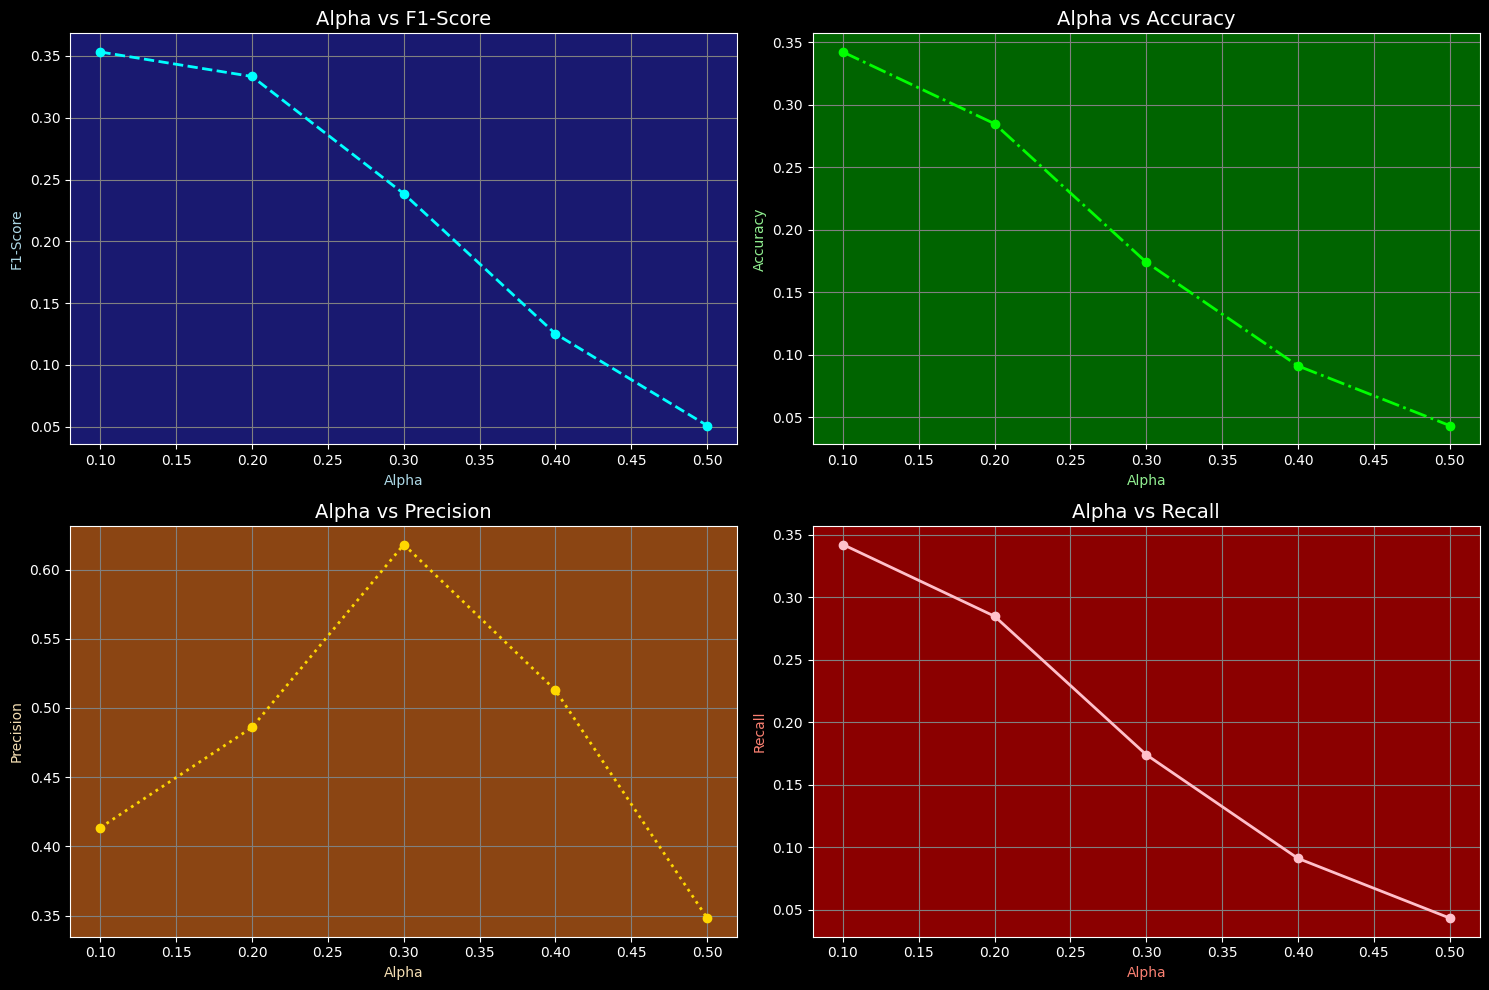

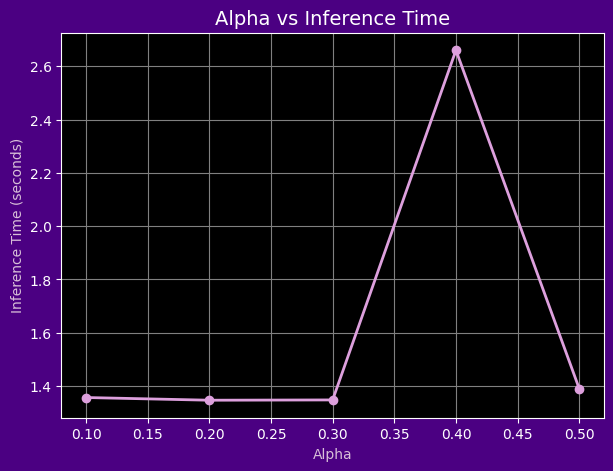

In [17]:
plt.style.use('dark_background')

plt.figure(figsize=(15, 10))

# Alpha vs F1-Score with a custom background color
plt.subplot(2, 2, 1, facecolor='midnightblue')
plt.plot(alpha_values, f1_scores, marker='o', color='cyan', linestyle='--', linewidth=2)
plt.title("Alpha vs F1-Score", fontsize=14, color='white')
plt.xlabel("Alpha", color='lightblue')
plt.ylabel("F1-Score", color='lightblue')
plt.grid(True, color='gray')

# Alpha vs Accuracy with a custom background color
plt.subplot(2, 2, 2, facecolor='darkgreen')
plt.plot(alpha_values, accuracies, marker='o', color='lime', linestyle='-.', linewidth=2)
plt.title("Alpha vs Accuracy", fontsize=14, color='white')
plt.xlabel("Alpha", color='lightgreen')
plt.ylabel("Accuracy", color='lightgreen')
plt.grid(True, color='gray')

# Alpha vs Precision with a custom background color
plt.subplot(2, 2, 3, facecolor='saddlebrown')
plt.plot(alpha_values, precisions, marker='o', color='gold', linestyle=':', linewidth=2)
plt.title("Alpha vs Precision", fontsize=14, color='white')
plt.xlabel("Alpha", color='wheat')
plt.ylabel("Precision", color='wheat')
plt.grid(True, color='gray')

# Alpha vs Recall with a custom background color
plt.subplot(2, 2, 4, facecolor='darkred')
plt.plot(alpha_values, recalls, marker='o', color='pink', linestyle='-', linewidth=2)
plt.title("Alpha vs Recall", fontsize=14, color='white')
plt.xlabel("Alpha", color='salmon')
plt.ylabel("Recall", color='salmon')
plt.grid(True, color='gray')

plt.tight_layout()
plt.show()

# Plot Inference Time vs. Alpha with custom background color separately
plt.figure(figsize=(7, 5), facecolor='indigo')
plt.plot(alpha_values, inference_times, marker='o', color='plum', linestyle='-', linewidth=2)
plt.title("Alpha vs Inference Time", fontsize=14, color='white')
plt.xlabel("Alpha", color='thistle')
plt.ylabel("Inference Time (seconds)", color='thistle')
plt.grid(True, color='gray')
plt.show()